![]()

# Stuff - uses the filter class

Kevin J. Walchko, Phd

24 Jan 2021

---

## Bosch BNO055

![](https://cdn-shop.adafruit.com/640x480/4646-00.jpg)

I will use this as a reference to determine how well I am doing. You can get a qwiic version from [Adafruit](https://www.adafruit.com/product/4646)

| Sensor         | Range            | Bits | Hz  |
|:---------------|------------------|------|-----|
| Accelerometer  | $\pm$4 g         | 14   | 100 |
| Gyroscopes     | $\pm$2000 dps    | 16   | 100 |
| Magnetic (x-y) | $\pm$1300 $\mu$T | -    | 20  |
| Magnetic (z)   | $\pm$2500 $\mu$T | -    | 20  |
| Temperature    | -40$^\circ$ to +85$^\circ$ | -    | 1   |

In [12]:
# reload library
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from slurm.rate import Rate

from squaternion import Quaternion

import pandas as pd

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

from filters.imufilter import IMUFilter
from filters.madgwick import MARG

from helper import getCode

from helper import Compressor
from helper import getData

>> imges: 178  imu: 894


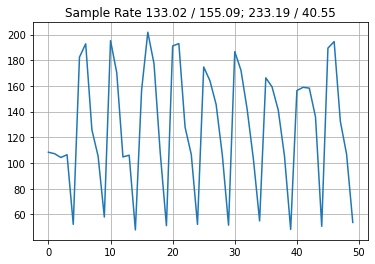

In [41]:
fname = "test2.pickle"

imgs, imu, bno, stamp = getData(fname)

print(f">> imges: {len(imgs)}  imu: {len(imu['accel'])}")

accel = np.array(imu["accel"])
gyro = np.array(imu["gyro"])

hz = 1/np.diff(stamp)

# plt.plot(stamp[1:],hz)
plt.plot(hz[:50])
plt.grid()
plt.title(f"Sample Rate {np.mean(hz):0.2f} / {np.median(hz):0.2f}; {max(hz):0.2f} / {min(hz):0.2f}");

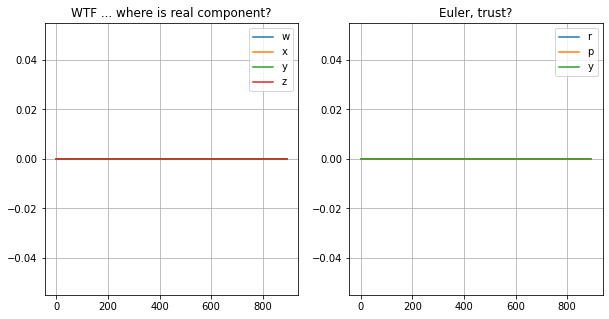

In [42]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(bno["q"]["w"],label="w")
plt.plot(bno["q"]["x"],label="x")
plt.plot(bno["q"]["y"],label="y")
plt.plot(bno["q"]["z"],label="z")
plt.grid(True)
plt.title("WTF ... where is real component?")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bno["euler"]["roll"],label="r")
plt.plot(bno["euler"]["pitch"],label="p")
plt.plot(bno["euler"]["yaw"],label="y")
plt.grid(True)
plt.title("Euler, trust?")
plt.legend();

# IMU Filter

In [15]:
# Let's look at the code
getCode(imp=IMUFilter)

In [23]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"time":[]}
qq = {"w":[], "x":[],"y":[], "z":[],"time":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time
B = sqrt(3/4)*2*pi/180  # gyro measurement error rad/s
filt = IMUFilter(B)
filt.wcomp = False
filt.wdr = 0.9
wes = []

for a, g, ts in zip(accel, gyro, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g,dt)  # get orientation
    qq["w"].append(q[0])
    qq["x"].append(q[1])
    qq["y"].append(q[2])
    qq["z"].append(q[3])
    qq["time"].append(ts-start) # keep track of test time
    
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    e["time"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

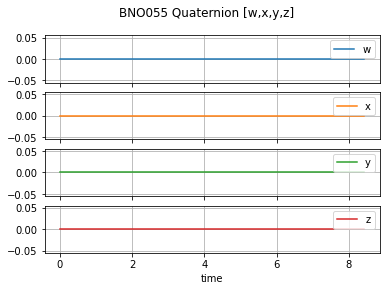

In [24]:
bnoq = pd.DataFrame(bno["q"])
bnoq.plot(
    x="time",
    subplots=True, grid=True, 
    title="BNO055 Quaternion [w,x,y,z]"
);

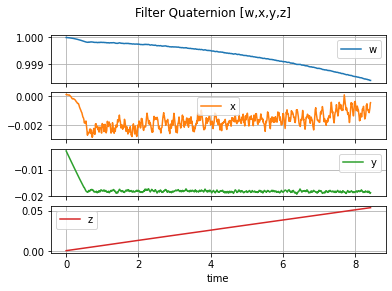

In [25]:
quat = pd.DataFrame(qq)
quat.plot(
    x="time", 
    subplots=True, grid=True, 
    title="Filter Quaternion [w,x,y,z]"
);

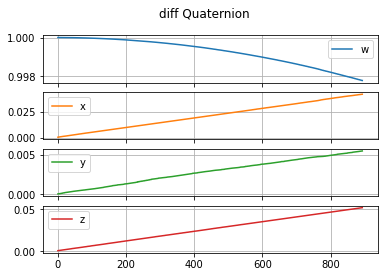

In [22]:
m = quat.iloc[:,:4] - bnoq.iloc[:,:4]
m.plot(
    subplots=True, grid=True, 
    title="diff Quaternion"
);

# MARG

In [24]:
# Let's look at the code
getCode(imp=MARG)

In [15]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"time":[]}
mq = {"w":[], "x":[], "y":[],"z":[],"time":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time

Z = sqrt(3/4)*0.0
B = sqrt(3/4)*0.01 # gyro measurement error rad/s
filt = MARG(B, Z)
filt.wcomp = True
filt.bias = np.array([-19.472,  33.003,  -1.579])
filt.M = np.array(
    [[0.987, 0.,    0.,   ],
     [0.,    0.964, 0.,   ],
     [0.,    0.,    1.,   ]]
)
wes = []

rad2deg = 180.0/np.pi

accel = np.array(imu["accel"])
gyro = np.array(imu["gyro"])
mag = np.array(imu["mag"])

for a, g, m, ts in zip(accel, gyro, mag, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g,m,dt)  # get orientation
    mq["w"].append(q.w)
    mq["x"].append(q.x)
    mq["y"].append(q.y)
    mq["z"].append(q.z)
    mq["time"].append(ts-start)
    
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    e["time"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

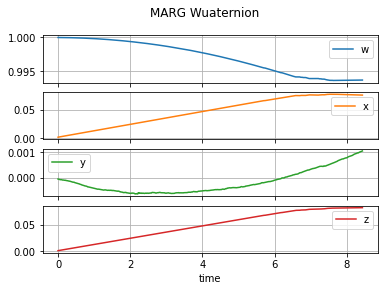

In [16]:
margq = pd.DataFrame(mq)
margq.plot(
    x="time", 
    subplots=True, 
    grid=True, 
    title="MARG Wuaternion"
);

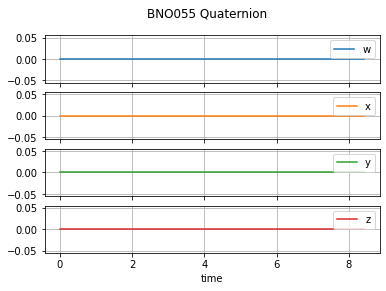

In [17]:
bnoquat = pd.DataFrame(bno["q"])
bnoquat.plot(
    x="time", 
    subplots=True, grid=True, 
    title="BNO055 Quaternion"
);

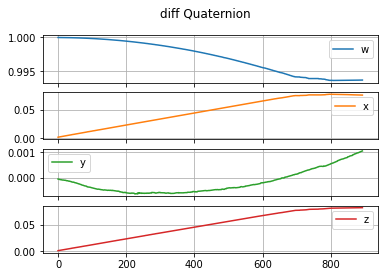

In [18]:
mm = margq.iloc[:,:4] - bnoquat.iloc[:,:4]
mm.plot(
    subplots=True, grid=True, 
    title="diff Quaternion"
);

# Camera

In [19]:
from ipywidgets import Video

Video.from_file("test.mp4", autoplay=False, loop=False, width=300, controls=True)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\xc2i\x17mdat\x00\x…